Importing the Libraries to perform the classification

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

Loading the Directory where the images are stored

In [2]:
PATH =os.getcwd()+'/COVID-19_Radiography_Dataset'

In [3]:
os.listdir(PATH)

['Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID']

Creating our Datasets for the analysis purpose

In [4]:
# Image generator for training (includes data augmentation)
imgTrainGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True, # Divide each input by its standard deviation]
    rescale=1./255, 
    zoom_range = 0.2, 
    validation_split = 0.2  
)

# Image generator for testing (didn't include augmentation)
imgTestGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True,
    rescale=1./255,
    validation_split = 0.2
)
# Build for training
trainGeneratorBuild = imgTrainGen.flow_from_directory(
    PATH,
    subset = 'training',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle= True
)
# Build for test
testGeneratorBuild = imgTestGen.flow_from_directory(
    PATH,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle=True
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


Exploratory Data Analysis

In [5]:
class_names = trainGeneratorBuild .class_indices
print(class_names)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [6]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [7]:
images,labels = next(trainGeneratorBuild)
labels = np.argmax(labels, axis=1)
class_dict = trainGeneratorBuild.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

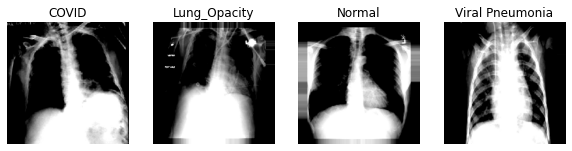

In [8]:
plt.figure(figsize=(10, 10))
for image in images:
    j  = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
        j = j+1

In [9]:
all_items,dirs,files = next(os.walk(PATH))

In [10]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(PATH,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)    
    

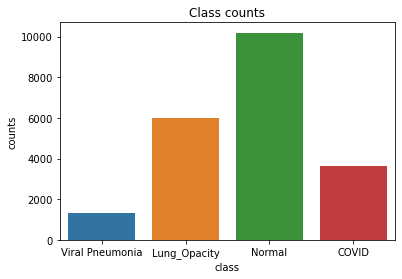

In [11]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

In [12]:
from keras.applications.resnet import ResNet50

In [13]:
res  = ResNet50( input_shape=(224,224,3), include_top=False) #using the final layer of resnet50 for our model to train.

Metal device set to: Apple M1


2021-11-12 12:25:34.625661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-12 12:25:34.626082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
from tensorflow.keras import Model

In [15]:
for layer in res.layers:
  layer.trainable = False
x= res.output
x=GlobalAveragePooling2D()(x)
#adding our own layers to train the model.
x= Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
out =layers.Dense(4, activation='softmax')(x)


# Creating our model
model = Model(inputs=res.input, outputs=out)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
 early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)

Setting our Checkpoint for finding the best fit from epoch and save it in h5 format

In [18]:
 mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [19]:

history=model.fit(trainGeneratorBuild,batch_size=32, epochs=10, validation_data=testGeneratorBuild,callbacks = [early_stop,mc],verbose=1)

2021-11-12 12:25:41.455028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-12 12:25:41.456157: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-11-12 12:25:42.115590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - ETA: 0s - loss: 0.8556 - accuracy: 0.6441

2021-11-12 12:28:31.971490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - 213s 401ms/step - loss: 0.8556 - accuracy: 0.6441 - val_loss: 0.6130 - val_accuracy: 0.7651

Epoch 00001: val_loss improved from inf to 0.61303, saving model to resnet_model.h5


/Users/aqdus/miniforge3/envs/mlp/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
530/530 [==============================] - 255s 481ms/step - loss: 0.6948 - accuracy: 0.7156 - val_loss: 0.6755 - val_accuracy: 0.7344

Epoch 00002: val_loss did not improve from 0.61303
Epoch 3/10
530/530 [==============================] - 291s 550ms/step - loss: 0.6370 - accuracy: 0.7459 - val_loss: 0.6018 - val_accuracy: 0.7647

Epoch 00003: val_loss improved from 0.61303 to 0.60184, saving model to resnet_model.h5
Epoch 4/10
530/530 [==============================] - 315s 594ms/step - loss: 0.6060 - accuracy: 0.7598 - val_loss: 0.5195 - val_accuracy: 0.8027

Epoch 00004: val_loss improved from 0.60184 to 0.51952, saving model to resnet_model.h5
Epoch 5/10
530/530 [==============================] - 307s 579ms/step - loss: 0.5844 - accuracy: 0.7661 - val_loss: 0.5220 - val_accuracy: 0.7871

Epoch 00005: val_loss did not improve from 0.51952
Epoch 6/10
530/530 [==============================] - 293s 552ms/step - loss: 0.5549 - accuracy: 0.7801 - val_loss: 0.5234 - val_accur

Calculating the overall Train and Test/Validation score

In [21]:
print("Train score:", model.evaluate(trainGeneratorBuild))
print("Test score:", model.evaluate(testGeneratorBuild))
n_epochs = len(history.history['loss'])

530/530 [==============================] - 166s 314ms/step - loss: 0.4915 - accuracy: 0.8038
Train score: [0.4915316104888916, 0.8038150668144226]
133/133 [==============================] - 42s 315ms/step - loss: 0.4452 - accuracy: 0.8336
Test score: [0.4451940953731537, 0.8336483836174011]


Plotting
1. Training and Validation accuracy
2. Training and Validation loss

In [22]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

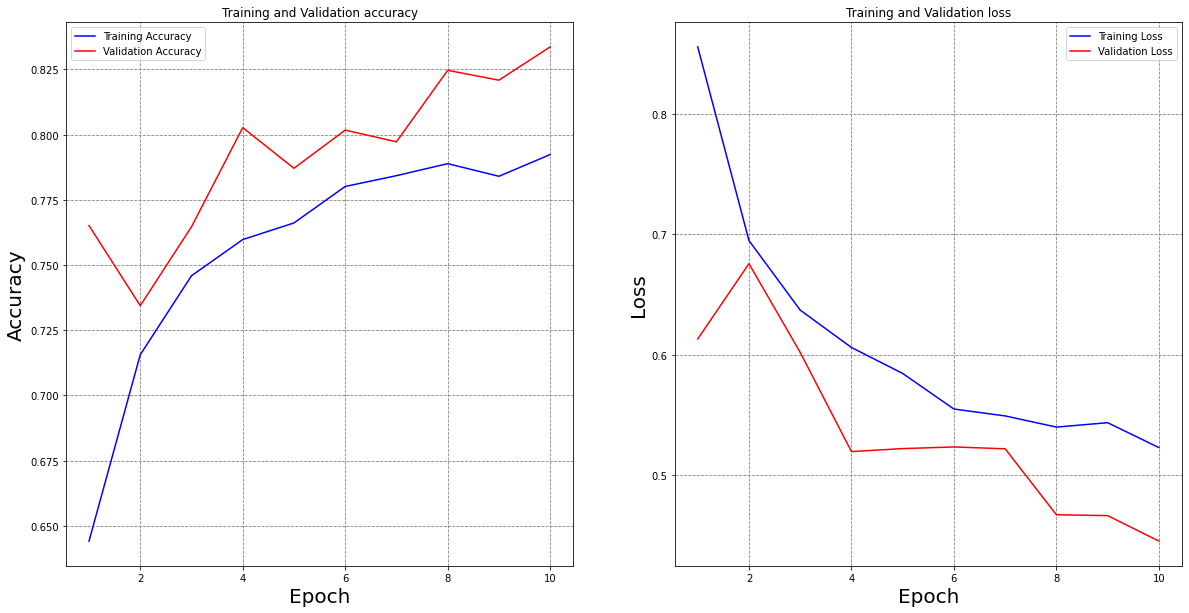

In [23]:
plotLearningCurve(history,n_epochs)

In [40]:
from tensorflow.keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

The given X-Ray image is of type = Normal

The chances of image being Covid is : 0.18743351101875305 percent

The chances of image being Lung_Opacity is : 0.00013675926311407238 percent

The chances of image being Normal is : 99.8123824596405 percent

The chances of image being Viral Pneumonia is : 3.9270068441510375e-05 percent


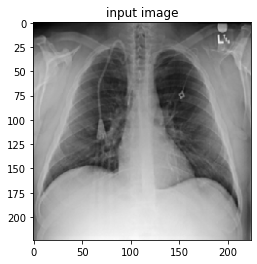

In [54]:
# path for that new image.
PATH =os.getcwd()+'/COVID-19_Radiography_Dataset/Normal/Normal-5.png'
class_names=['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# you can add any image path
img = get_img_array(PATH)

res = class_names[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Lung_Opacity is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][2]*100} percent")
print()
print(f"The chances of image being Viral Pneumonia is : {model.predict(img)[0][3]*100} percent")



# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()